In [1]:
# Jupyter magic

%load_ext autoreload
%autoreload 2

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import cma
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append('/home/ubuntu/proj/bayesian-algorithm-execution')

from bax.estool.es import CMAES

In [3]:
# Set random seed

random_seed = 11
np.random.seed(random_seed)

In [4]:
# from https://github.com/CMA-ES/pycma/blob/master/cma/fitness_functions.py

def rastrigin(x):
  """Rastrigin test objective function, shifted by 10. units away from origin"""
  x = np.copy(x)
  x -= 10.0
  if not np.isscalar(x[0]):
    N = len(x[0])
    return -np.array([10 * N + sum(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in x])
  N = len(x)
  return -(10 * N + sum(x**2 - 10 * np.cos(2 * np.pi * x)))

fit_func = rastrigin

In [5]:
NPARAMS = 10         # make this a 10-dimensinal problem.
NPOPULATION = 50     # use population size of 50.
MAX_ITERATION = 40   # run each solver for 40 generations.
QUERY_PROP = 0.1     # proportion of queries to conduct

In [6]:
#     print('IN GET PREDICTOR')
#     print(f'type(prev_gen_fitnesses): {type(prev_gen_fitnesses)}')
#     print(f'type(curr_gen_fitnesses): {type(curr_gen_fitnesses)}')
#     print(f'len(prev_gen_fitnesses): {len(prev_gen_fitnesses)}')
#     print(f'len(curr_gen_fitnesses): {len(curr_gen_fitnesses)}')
#     print(f'prev_gen_fitnesses: {prev_gen_fitnesses}')
#     print(f'curr_gen_fitnesses: {curr_gen_fitnesses}')
#     input()
#     print(f'type(prev_gen_solutions): {type(prev_gen_solutions)}')
#     print(f'type(curr_gen_solutions): {type(curr_gen_solutions)}')
#     print(f'len(prev_gen_solutions): {len(prev_gen_solutions)}')
#     print(f'len(curr_gen_solutions): {len(curr_gen_solutions)}')
#     print(f'prev_gen_solutions: {prev_gen_solutions}')
#     print(f'curr_gen_solutions: {curr_gen_solutions}')
#     input()

In [7]:
def get_predictor(x_only_true_gen, y_only_true_gen, x_only_true, y_only_true):
    """Return predictor."""

    # Set training data
    n_train_prev_gen = 150
    
    x_list = x_only_true_gen + x_only_true[-n_train_prev_gen:]
    y_list = y_only_true_gen + y_only_true[-n_train_prev_gen:]
    
    # Define predictor
    predictor = RandomForestRegressor(max_depth=None,
                                      random_state=random_seed,
                                      n_estimators=50,
                                      criterion='mse')

    # Fit predictor
    predictor.fit(x_list, y_list)

    return predictor

In [8]:
def query_generation(x_gen, x_only_true, y_only_true):
    """Perform a single generation of ES"""
    n_gen = len(x_gen)
    n_cutoff = int(QUERY_PROP * n_gen)
    
    # Initialize arrays holding this gen's fitness function values (or predictions)
    y_pred_true_gen = []
    y_all_true_gen = []
    x_only_true_gen = []
    y_only_true_gen = []

    # Loop through each element of generation and query function or predict
    for i in range(n_gen):
        if i >= n_cutoff and len(x_only_true) > 100:

            if i == n_cutoff:
                print('Setting and fitting predictor')
                predictor = get_predictor(x_only_true_gen, y_only_true_gen, x_only_true, y_only_true)

            # Prediction function query
            input_to_pred = np.array(x_gen[i]).reshape(1, -1)
            prediction = predictor.predict(input_to_pred)
            #prediction = y_pred_true_gen[n_cutoff - 1]

        else:
            # Perform true function query
            prediction = fit_func(x_gen[i])
            x_only_true_gen.append(x_gen[i])
            y_only_true_gen.append(prediction)

        # Store predicted function value
        y_pred_true_gen.append(prediction)
        
        # Also store true function value
        y_all_true_gen.append(fit_func(x_gen[i]))
    
    return y_pred_true_gen, y_all_true_gen, x_only_true_gen, y_only_true_gen

In [9]:
# defines a function to use solver to solve fit_func

def test_solver(solver, print_mod=10):
  print('NEW TEST SOLVER')
  y_all_true = []
  y_pred_true = []
  x_all = []

  x_only_true = []
  y_only_true = []

  history = []

  # Iterate through generations
  for j in range(MAX_ITERATION):
    
    # Select next generation of queries
    x_gen_arr = solver.ask()
    x_gen = [list(x) for x in x_gen_arr]
    
    # Query/predict fitness function values
    y_pred_true_gen, y_all_true_gen, x_only_true_gen, y_only_true_gen = query_generation(x_gen, x_only_true, y_only_true)
    
    # Update solver and history
    solver.tell(y_pred_true_gen)
    result = solver.result() # first element is the best solution, second element is the best fitness
    history.append(result[1])

    # Update lists
    y_pred_true.extend(y_pred_true_gen)
    y_all_true.extend(y_all_true_gen)
    x_all.extend(x_gen)
    
    x_only_true.extend(x_only_true_gen)
    y_only_true.extend(y_only_true_gen)

    if (j+1) % print_mod == 0:
      print("fitness at iteration", (j+1), result[1])

  print("local optimum discovered by solver:\n", result[0])
  print("fitness score at this local optimum:", result[1])
  return history, y_all_true

In [10]:
# Initial point

x = np.zeros(NPARAMS)

print(f'Initial point x = {x}')
print(f'f(x) = {fit_func(x)}')

Initial point x = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
f(x) = -1000.0


In [11]:
# Optimal point

x = np.ones(NPARAMS)*10.0

print(f'Global optimum point x = {x}')
print(f'f(x) = {fit_func(x)}')

Global optimum point x = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
f(x) = -0.0


In [12]:
# defines CMA-ES algorithm solver

cmaes = CMAES(NPARAMS,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = 0.5
          )

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=345228, Sat Oct 31 18:01:45 2020)


In [13]:
cma_history, cma_fitness_list = test_solver(cmaes)

NEW TEST SOLVER
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
fitness at iteration 10 -312.99677923598387
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
fitness at iteration 20 -180.6723674197853
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
Setting and fitting predictor
fitness at iteration 30 -151.27149095581416
Setting and fitting predictor
Setting and f

In [14]:
# Compute best-so-far (bsf) array

cma_bsf = np.maximum.accumulate(cma_fitness_list)

(-2000.0, 50.0)

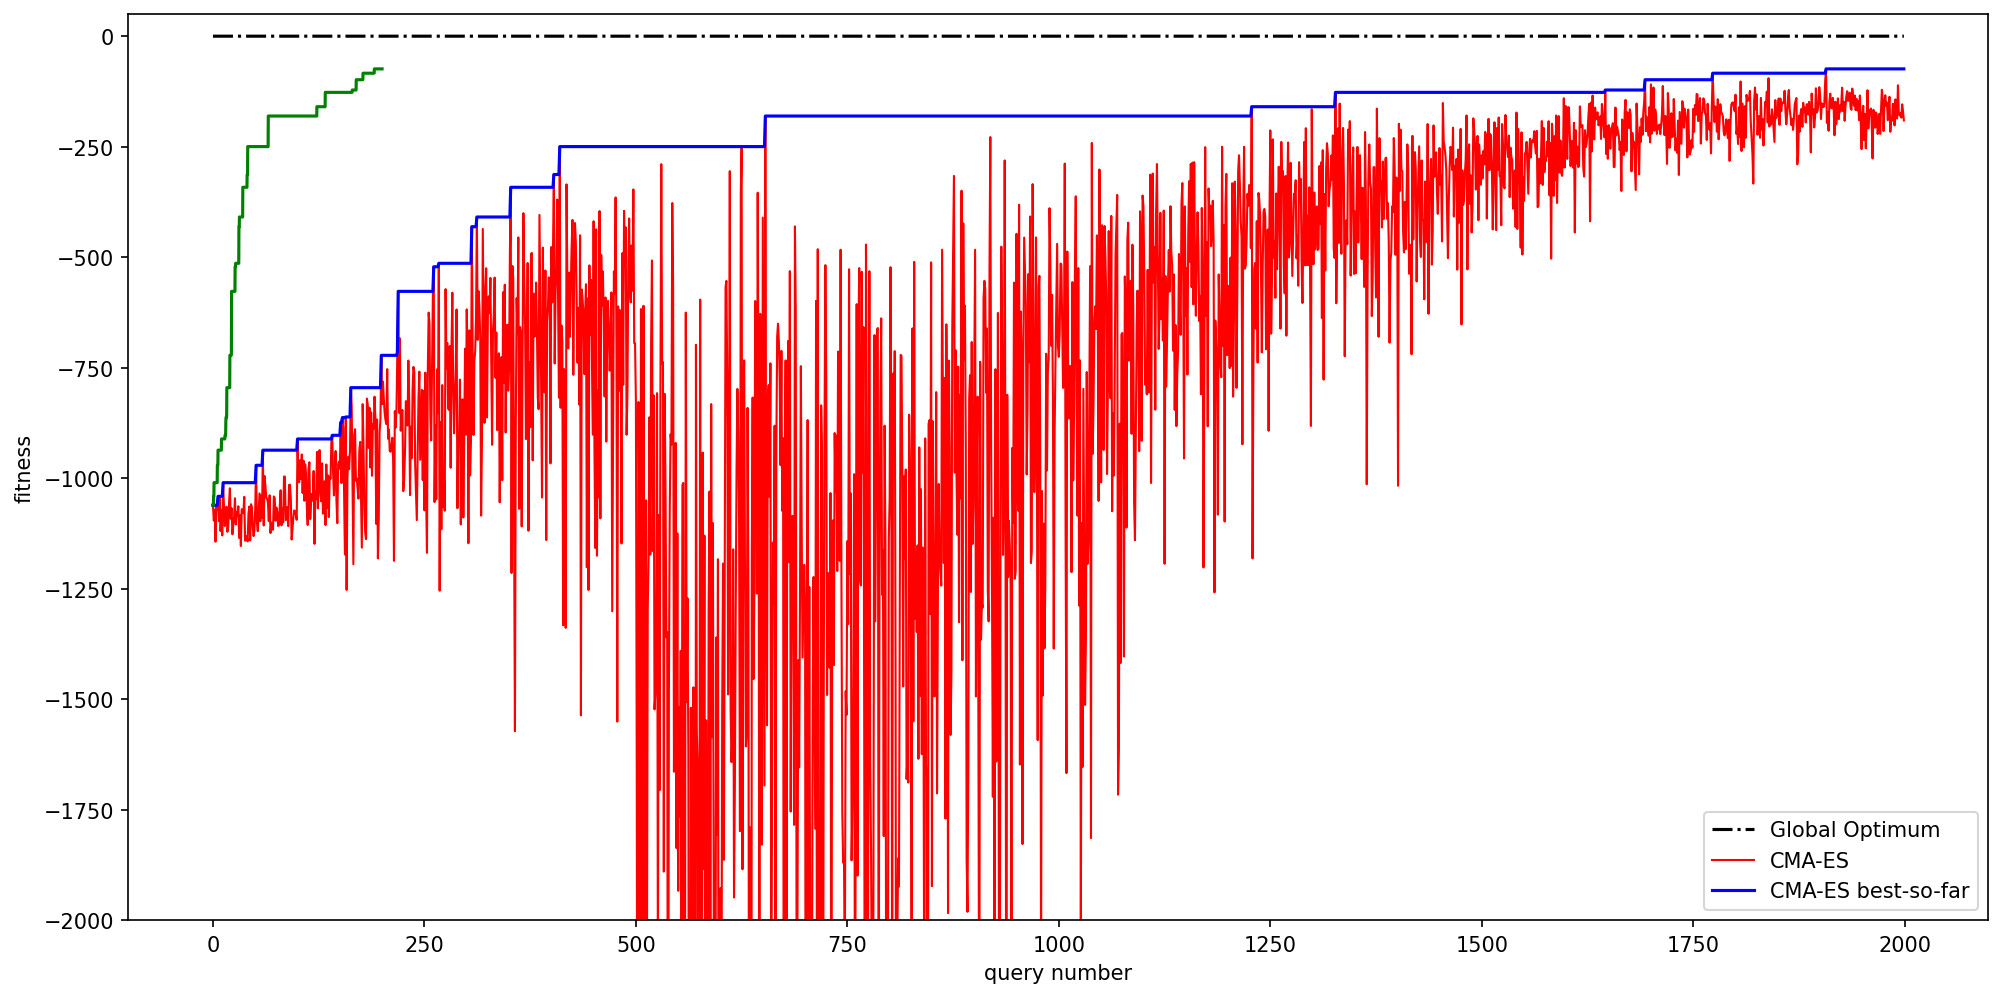

In [15]:
best_history = [0] * MAX_ITERATION * NPOPULATION
plt.figure(figsize=(16,8), dpi=150)

optimum_line, = plt.plot(best_history, color="black", linewidth=1.5, linestyle="-.", label='Global Optimum')
cma_line, = plt.plot(cma_fitness_list, color="red", linewidth=1.0, linestyle="-", label='CMA-ES')
cma_bsf_line, = plt.plot(cma_bsf, color="blue", linewidth=1.5, linestyle="-", label='CMA-ES best-so-far')
scaled_queries = QUERY_PROP * np.array(range(len(cma_bsf)))
cma_bsf_line_scaled, = plt.plot(scaled_queries, cma_bsf, color="green", linewidth=1.5, linestyle="-", label='CMA-ES best-so-far scaled')

plt.legend(handles=[optimum_line, cma_line, cma_bsf_line], loc=4)

plt.xlabel('query number')
plt.ylabel('fitness')

plt.ylim([-2000, 50])

# plt.savefig("./rastrigin_example.svg")